In [1]:
import os

os.chdir("../")
print(os.getcwd())

c:\Users\risko\Desktop\Prompt-Classification


In [2]:
import pickle
import random
import statistics
import time

import numpy as np
import pandas as pd
from dotenv import load_dotenv
from fastembed import TextEmbedding
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from tqdm import tqdm
from xgboost import XGBClassifier

from prompt_classifier.metrics import evaluate
from prompt_classifier.modeling.dspy_gpt import GPT4oMini
from prompt_classifier.modeling.fasttext import FastTextClassifier

#from prompt_classifier.modeling.nli_modernbert import ModernBERTNLI

load_dotenv()
random.seed(42)

c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
law_prompts = pd.read_csv('data/processed/law_prompts.csv')
general_prompts = pd.read_csv('data/processed/general_prompts.csv')
healthcare_prompts = pd.read_csv('data/processed/healthcare_prompts.csv')
finance_prompts = pd.read_csv('data/processed/finance_prompts.csv')

law_dataset = pd.concat([law_prompts, general_prompts]).sample(frac=1).reset_index(drop=True)
healthcare_dataset = pd.concat([healthcare_prompts, general_prompts]).sample(frac=1).reset_index(drop=True)
finance_dataset = pd.concat([finance_prompts, general_prompts]).sample(frac=1).reset_index(drop=True)

datasets = {'law': law_dataset, 'healthcare': healthcare_dataset, 'finance': finance_dataset}

In [4]:
law_prompts_interim = pd.read_csv('data/interim/law_prompts.csv')
general_prompts_interim = pd.read_csv('data/interim/general_prompts.csv')
healthcare_prompts_interim = pd.read_csv('data/interim/healthcare_prompts.csv')
finance_prompts_interim = pd.read_csv('data/interim/finance_prompts.csv')

law_dataset_interim = pd.concat([law_prompts_interim, general_prompts_interim]).sample(frac=1).reset_index(drop=True)
healthcare_dataset_interim = pd.concat([healthcare_prompts_interim, general_prompts_interim]).sample(frac=1).reset_index(drop=True)
finance_dataset_interim = pd.concat([finance_prompts_interim, general_prompts_interim]).sample(frac=1).reset_index(drop=True)

datasets_interim = {'law': law_dataset_interim, 'healthcare': healthcare_dataset_interim, 'finance': finance_dataset_interim}

# GPT and ModernBERT loop using interim data

In [ ]:

for domain, dataset in datasets_interim.items():
    train_data = dataset.sample(frac=0.00025)
    test_data = dataset.drop(train_data.index).head(100)

    gpt_classifier = GPT4oMini(api_key=os.getenv("OPENAI_API_KEY"), proxy_url=os.getenv("PROXY_URL"), model_name="gpt-4o-mini",
                            domain=domain, train_data=train_data, test_data=test_data)


    gpt_classifier.optimize_model()

    predictions, actuals, mean_latency = gpt_classifier.predict()

    evaluate(predictions=predictions, true_labels=actuals, domain=domain, model_name="gpt4o-mini", embed_model="ada-002", cost=gpt_classifier.cost, latency=mean_latency)

    gpt_classifier.save_model(f"models/gpt-4o-mini-{domain}.json")

    break

    actuals = []
    predictions = []
    prediction_times = []

    # ModernBERT
    bert_classifier = ModernBERTNLI(domain=domain)
    for _, row in tqdm(dataset.iterrows(), total=len(dataset)):

        start_time = time.perf_counter_ns()
        prediction = bert_classifier.predict(row['prompt'])
        end_time = time.perf_counter_ns()

        actuals.append(row['label'])
        prediction_times.append(end_time - start_time)

        mean_prediction_time = statistics.mean(prediction_times)

    evaluate(predictions, actuals, domain, model_name='ModernBERT', embed_model='modernbert', latency=mean_prediction_time)


# SVM, fastText and XGBoost loop using processed data

In [5]:
baai_embedding = TextEmbedding(model_name="BAAI/bge-small-en-v1.5")
tf_idf_embedding = TfidfVectorizer()
mini_embedding = TextEmbedding(model_name="sentence-transformers/all-MiniLM-L6-v2")

embedding_models = {'mini': mini_embedding, 'tf_idf': tf_idf_embedding, 'baai': baai_embedding}

100%|██████████| 8000/8000 [00:00<00:00, 14216.93it/s]


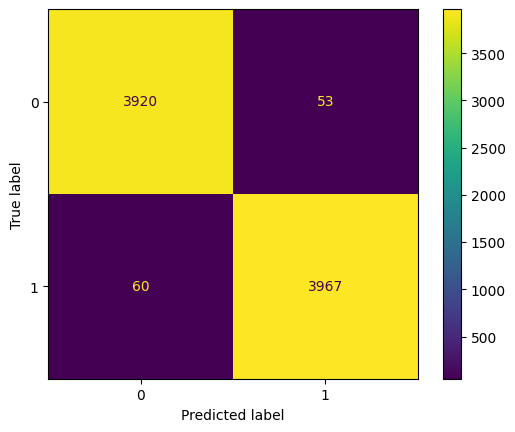

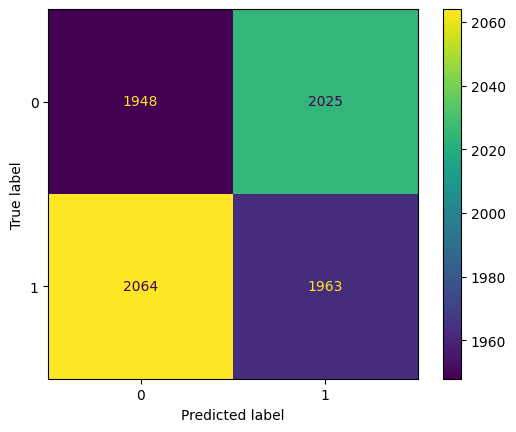

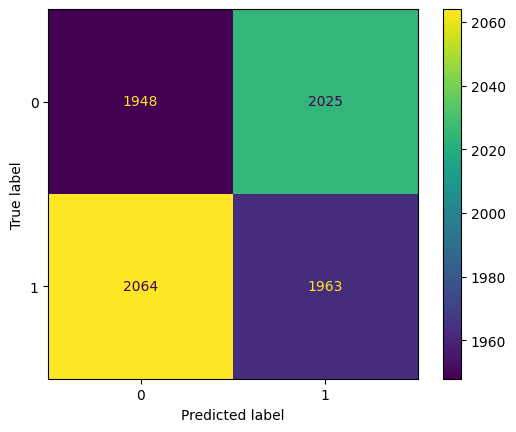

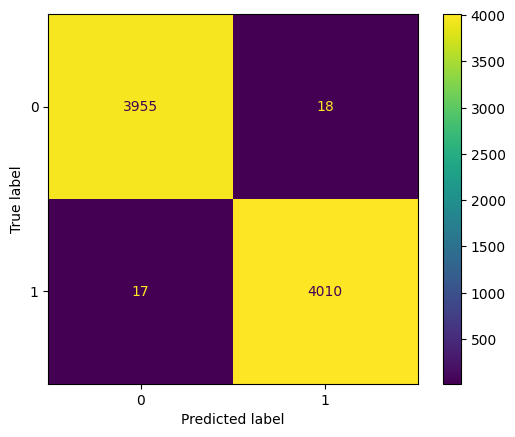

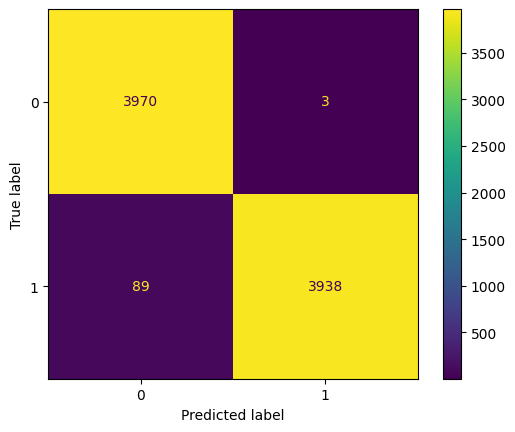

In [ ]:
for domain, dataset in datasets.items():
    train_data = dataset.sample(frac=0.8).reset_index(drop=True)
    test_data = dataset.drop(train_data.index).reset_index(drop=True)

    actuals = []
    predictions = []
    prediction_times = []

    # fastText
    fasttext_classifier = FastTextClassifier(train_data=train_data, test_data=test_data)
    fasttext_classifier.train()

    for _, row in tqdm(test_data.iterrows(), total=len(test_data)):
        text = str(row['prompt'])
        query = text.replace('\n', '')

        start_time = time.perf_counter_ns()
        prediction = fasttext_classifier.model.predict(query)
        end_time = time.perf_counter_ns()

        prediction_times.append(end_time - start_time)

        if prediction[0][0] == '__label__1':
            predictions.append(1)
        else:
            predictions.append(0)

        actuals.append(row['label'])

    mean_prediction_time = statistics.mean(prediction_times)
    evaluate(predictions, actuals, domain, model_name='fastText', embed_model='fasttext', latency=mean_prediction_time)

    fasttext_classifier.model.save_model(f"models/fastText_{domain}_fasttext.bin")

    # SVM and XGBoost with different embeddings
    for model_name, embedding_model in embedding_models.items():
        print(f"Training {model_name} on {domain} domain with {embedding_model} embeddings")
        
        if model_name == 'tf_idf':
            embedding_model.fit(train_data['prompt'])
            with open(f"models/tfidf_{domain}.pkl", 'wb') as f:
                pickle.dump(embedding_model, f)
            train_embeds = embedding_model.transform(train_data['prompt'])
            test_embeds = embedding_model.transform(test_data['prompt'])
        else:
            train_embeds = list(embedding_model.embed(train_data['prompt']))
            test_embeds = list(embedding_model.embed(train_data['prompt']))
            train_embeds = np.array(train_embeds).reshape(len(train_embeds), -1)
            test_embeds = np.array(test_embeds).reshape(len(test_embeds), -1)

        actuals = []
        predictions = []
        prediction_times = []

        # SVM
        svm_classifier = SVC()
        svm_classifier.fit(train_embeds, train_data['label'])


        for i, row in test_data.iterrows():
            start_time = time.perf_counter_ns()
            prediction = svm_classifier.predict(test_embeds[i].reshape(1, -1))
            end_time = time.perf_counter_ns()

            prediction_times.append(end_time - start_time)
            predictions.append(prediction[0])
            actuals.append(row['label'])

        mean_prediction_time = statistics.mean(prediction_times)
        evaluate(predictions, actuals, domain, model_name='SVM', embed_model=model_name, latency=mean_prediction_time)

        with open(f"models/SVM_{domain}_{model_name}.pkl", 'wb') as f:
            pickle.dump(svm_classifier, f)

        actuals = []
        predictions = []
        prediction_times = []

        # XGBoost
        xgboost_classifier = XGBClassifier(n_jobs = -1)
        xgboost_classifier.fit(train_embeds, train_data['label'])

        for i, row in test_data.iterrows():
            start_time = time.perf_counter_ns()
            prediction = xgboost_classifier.predict(test_embeds[i].reshape(1, -1))
            end_time = time.perf_counter_ns()
            prediction_times.append(end_time - start_time)
            predictions.append(prediction[0])
            actuals.append(row['label'])

        mean_prediction_time = statistics.mean(prediction_times)
        evaluate(predictions, actuals, domain, model_name='XGBoost', embed_model=model_name, latency=mean_prediction_time)

        xgboost_classifier.save_model(f"models/XGBoost_{domain}_{model_name}.json")